In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import os
from scipy.stats import mannwhitneyu, zscore
from function import barplot_annotate_brackets
import baltic as bt
import logomaker
import warnings
warnings.simplefilter('ignore')

In [2]:
os.makedirs('../Figure/Figure3', exist_ok=True)

# Load raw data

In [3]:
screening_result = pd.read_csv('../data/screening/screening_TE_evasion_candidates.csv')
print(len(screening_result))
screening_result.head()

62


,repeat family name,KZFP gene symbol,subfamily1,subfamily2,difference of binding rate,decrease in younger subfamily?,adjusted p value,subfamily1 binding rate,subfamily2 binding rate,repeat class,repeat region,subfamily1 branch,subfamily2 branch,subfamily1 age,subfamily2 age,KZFP age
0,MER11,ZNF808,MER11B,MER11D,1.0000,decrease,0.0,1.000000,0.0,ERV/LTR,LTR,Catarrhini,Hominoidea,29.4,20.2,29.4
1,Harlequin,ZNF534,Harlequin_3,Harlequin_1,0.7317,decrease,0.0,0.731707,0.0,ERV/LTR,Int,Catarrhini,Hominoidea,29.4,20.2,96.0
2,MER11,ZNF440,MER11B,MER11D,0.6667,decrease,0.0,0.666667,0.0,ERV/LTR,LTR,Catarrhini,Hominoidea,29.4,20.2,29.4
3,MER65,ZNF780B,MER65C,MER65B,0.6269,decrease,0.0,0.626911,0.0,ERV/LTR,LTR,Primatomorpha,Primates,76.0,74.0,74.0
4,LTR7,ZNF808,LTR7YY,LTR7up3,0.5818,decrease,0.0,0.581818,0.0,ERV/LTR,LTR,Hominoidea,Homininae,20.2,9.1,29.4


# Fig.3B

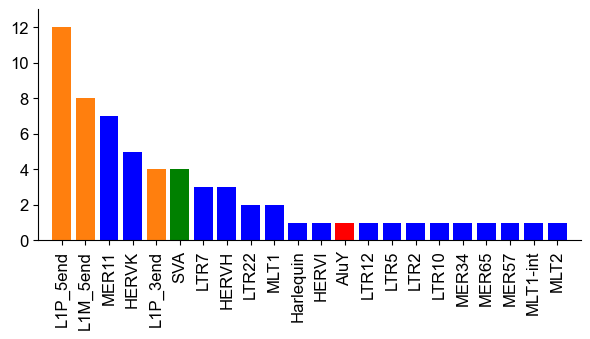

In [4]:
TE_class_list = ['DNA', 'ERV/LTR', 'ERV/Int', 'LINE', 'SINE', 'Retroposon']
TE_color_dict = {'ERV/LTR': 'blue', 'LINE': 'orange', 'Retroposon': 'green', 'SINE':'red'}

fig = plt.figure(figsize=[7, 3])
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

data = screening_result[['repeat family name', 'repeat class']].value_counts().rename('count').to_frame().reset_index()
TE_color_dict = {'ERV/LTR': 'blue', 'LINE': 'tab:orange', 'Retroposon': 'green', 'SINE':'red'}

x = data['repeat family name']
y = data['count']
color = [TE_color_dict[TE] for TE in data['repeat class']]

plt.bar(x=x, height=y, color=color)
ticks = plt.xticks(rotation=90)
plt.yticks(ticks=[0, 2, 4, 6, 8, 10, 12])
#plt.xlabel('TE family name')
#plt.ylabel('candidate of\nevasion event')
plt.xlabel('')
plt.ylabel('')
plt.xlim(-1, 22)
plt.ylim(0, 13)

# Legend
for TE_class, color in TE_color_dict.items():

    p = plt.scatter([-3], [-1], marker='.', label=TE_class, color=color)

plt.legend(loc=[0.7, 0.5], ncol=1, fontsize=12, frameon=False)
plt.legend().remove()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

fig.savefig('../Figure/Figure3/Figure3B.png', bbox_inches='tight', dpi=300)
fig.savefig('../Figure/Figure3/Figure3B.pdf', bbox_inches='tight', transparent=True, dpi=300)
#plt.legend()

# Load MER11 data

In [5]:
family = 'MER11'

Dfam_RM = pd.read_csv('../data/TE/{}.annotation.csv'.format(family))
Dfam_RM.index = Dfam_RM['repeat name']
screening_result = pd.read_csv('../data/screening/{}_screening.csv'.format(family))
Lift_summary_df = pd.read_csv('../data/Liftover/{}_Liftover.csv'.format(family), index_col=0)
Lift_df = pd.read_csv('../data/Liftover/{}_Liftover_rate.csv'.format(family), index_col=0)
KZFP_df = pd.read_csv('../data/overlap/{}_KZFP.csv'.format(family))
TRIM28_df = pd.read_csv('../data/overlap/{}_TRIM28.csv'.format(family))
MSA_df = pd.read_csv('../data/MSA/{}_MSA.csv'.format(family), index_col=0)
MSA_df.columns = list(map(int, MSA_df.columns))
tree = bt.loadNewick('../data/phylogenetic tree/{}_reroot.contree'.format(family))

In [6]:
conserved_dict = dict()

for subfamily in Lift_df.index:

    conserved_df = pd.read_csv('../data/MSA/conserved/{}_conserved.csv'.format(subfamily), index_col=0)
    conserved_df.columns = conserved_df.columns.astype('int64')
    conserved_dict[subfamily] = conserved_df

In [7]:
# obtain binding site
motif_metadata_df = pd.read_csv('../data/motif/TE_KZFP_binding_sites.csv')

# filtering
condition1 = (motif_metadata_df['discovery proportion']>=50) & (motif_metadata_df['log10 p-value']>=4)
condition2 = motif_metadata_df['motif start'] != motif_metadata_df['motif end']
condition3 = motif_metadata_df['repeat family name']==family
motif_metadata_df_fil = motif_metadata_df[condition1 & condition2 & condition3].sort_values(by='log10 p-value', ascending=False)
motif_metadata_df_nodup = motif_metadata_df_fil[motif_metadata_df_fil[['repeat family name', 'KZFP gene symbol']].duplicated()==False]
motif_metadata_df_nodup

,repeat family name,KZFP gene symbol,KZFP experiment,motif start,motif end,motif center,motif strand,peak overlap motif,discovery proportion,distance to peak summit,log10 p-value,E-value significant figure,E-value log10
29,MER11,ZNF525,GSE78099,970.0,990.0,980,-,405.0,68.994889,17.180247,11.659556,7.6,52
12,MER11,ZNF468,GSE78099,1251.0,1271.0,1261,+,193.0,76.587302,7.248705,6.497573,1.7,817
28,MER11,ZNF433,GSE78099,305.0,319.0,312,-,85.0,63.909774,10.952941,6.344862,2.4,498
30,MER11,ZNF727,GSE200964,1088.0,1259.0,1173,+,105.0,65.217391,14.009524,5.291579,7.2,169
31,MER11,ZNF736,GSE78099,670.0,684.0,677,+,40.0,75.471698,17.525000,4.673664,1.1,1021


In [8]:
# obtain motif

from Bio import motifs

motif_matrix_df = dict()
for KZFP, exp in motif_metadata_df_nodup[['KZFP gene symbol', 'KZFP experiment']].value_counts().index:

    with open('../data/motif/raw_motif/{}_{}_motif_sig_500_231120.meme'.format(KZFP, exp)) as f:

        fr = f.read().split('\n')

        check = False
        motif_list = list()
        for line in fr:

            if 'letter' in line:
                check = True
            
            elif check and '\t' in line:

                value = [float(i) for i in line.replace(' ', '').split('\t')[:4]]
                motif_list.append(value)
        
    df = pd.DataFrame(motif_list, columns=['A', 'C', 'G', 'T'])
    motif_matrix_df[(KZFP, exp)] = df

# Process MER11 data

In [9]:
# load TE targets
KZFP_target = pd.read_csv('../data/targets/TE_targets_for_analysis.csv')
KZFP_target = KZFP_target[(KZFP_target['repeat family name']==family)].sort_values(by='q value')
display(pd.unique(KZFP_target['KZFP gene symbol']))

array(['ZNF611', 'ZNF33A', 'ZNF808', 'ZNF578', 'ZNF727', 'ZNF433',
       'ZNF440', 'ZNF468', 'ZNF525', 'ZNF445', 'ZNF736', 'ZNF528'],
      dtype=object)

In [10]:
color_subfamily_dict = dict()
color_name_dict = dict()

color_list = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink']
branch_list = ['Vertebrata', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria', 'Boreoeutheria', 'Euarchontoglires', 'Primatomorpha', 
               'Primates', 'Haplorrhini', 'Simiiformes', 'Catarrhini', 'Hominoidea', 'Hominidae', 'Homininae', 'Hominini']

subfamily_list = ['MER11_2', 'MER11_3', 'MER11_5', 'MER11_0', 'MER11_4', 'MER11_1']

color_list = ['blue', 'red', 'yellow', 'green', 'purple', 'orange', 'pink', 'red']


for i, (subfamily, color) in enumerate(zip(subfamily_list, color_list)):

    color_subfamily_dict[subfamily] = color

        
for i, (subfamily, name) in enumerate(Dfam_RM[['repeat adjusted subfamily name', 'repeat name']].values):

    color_name_dict[name] = color_subfamily_dict[subfamily]

c_func = lambda x: color_name_dict[x.name] if x.name in color_name_dict.keys() else 'black'
x_attr= lambda x: x.absoluteTime

# Fig.3C

In [11]:
# obrain KZFP binding to each MER11 copy
crosstab = pd.crosstab(KZFP_df['repeat name'], KZFP_df['KZFP gene symbol'])
Dfam_RM_KZFP = pd.concat([Dfam_RM, crosstab>=1], axis=1)
Dfam_RM_KZFP = Dfam_RM_KZFP[Dfam_RM_KZFP['repeat name'].isna()==False]
Dfam_RM_KZFP = Dfam_RM_KZFP.fillna(False)

['ZNF808' 'ZNF440' 'ZNF525' 'ZNF468' 'ZNF433' 'ZNF445' 'ZNF33A']
['ZNF611' 'ZNF33A' 'ZNF808' 'ZNF578' 'ZNF727' 'ZNF433' 'ZNF440' 'ZNF468'
 'ZNF525']
10
MER11 {'ZNF445': 'tab:blue', 'ZNF525': 'tab:orange', 'ZNF727': 'tab:green', 'ZNF433': 'tab:red', 'ZNF611': 'tab:purple', 'ZNF578': 'tab:brown', 'ZNF33A': 'tab:pink', 'ZNF808': 'tab:gray', 'ZNF468': 'tab:olive', 'ZNF440': 'tab:cyan'}


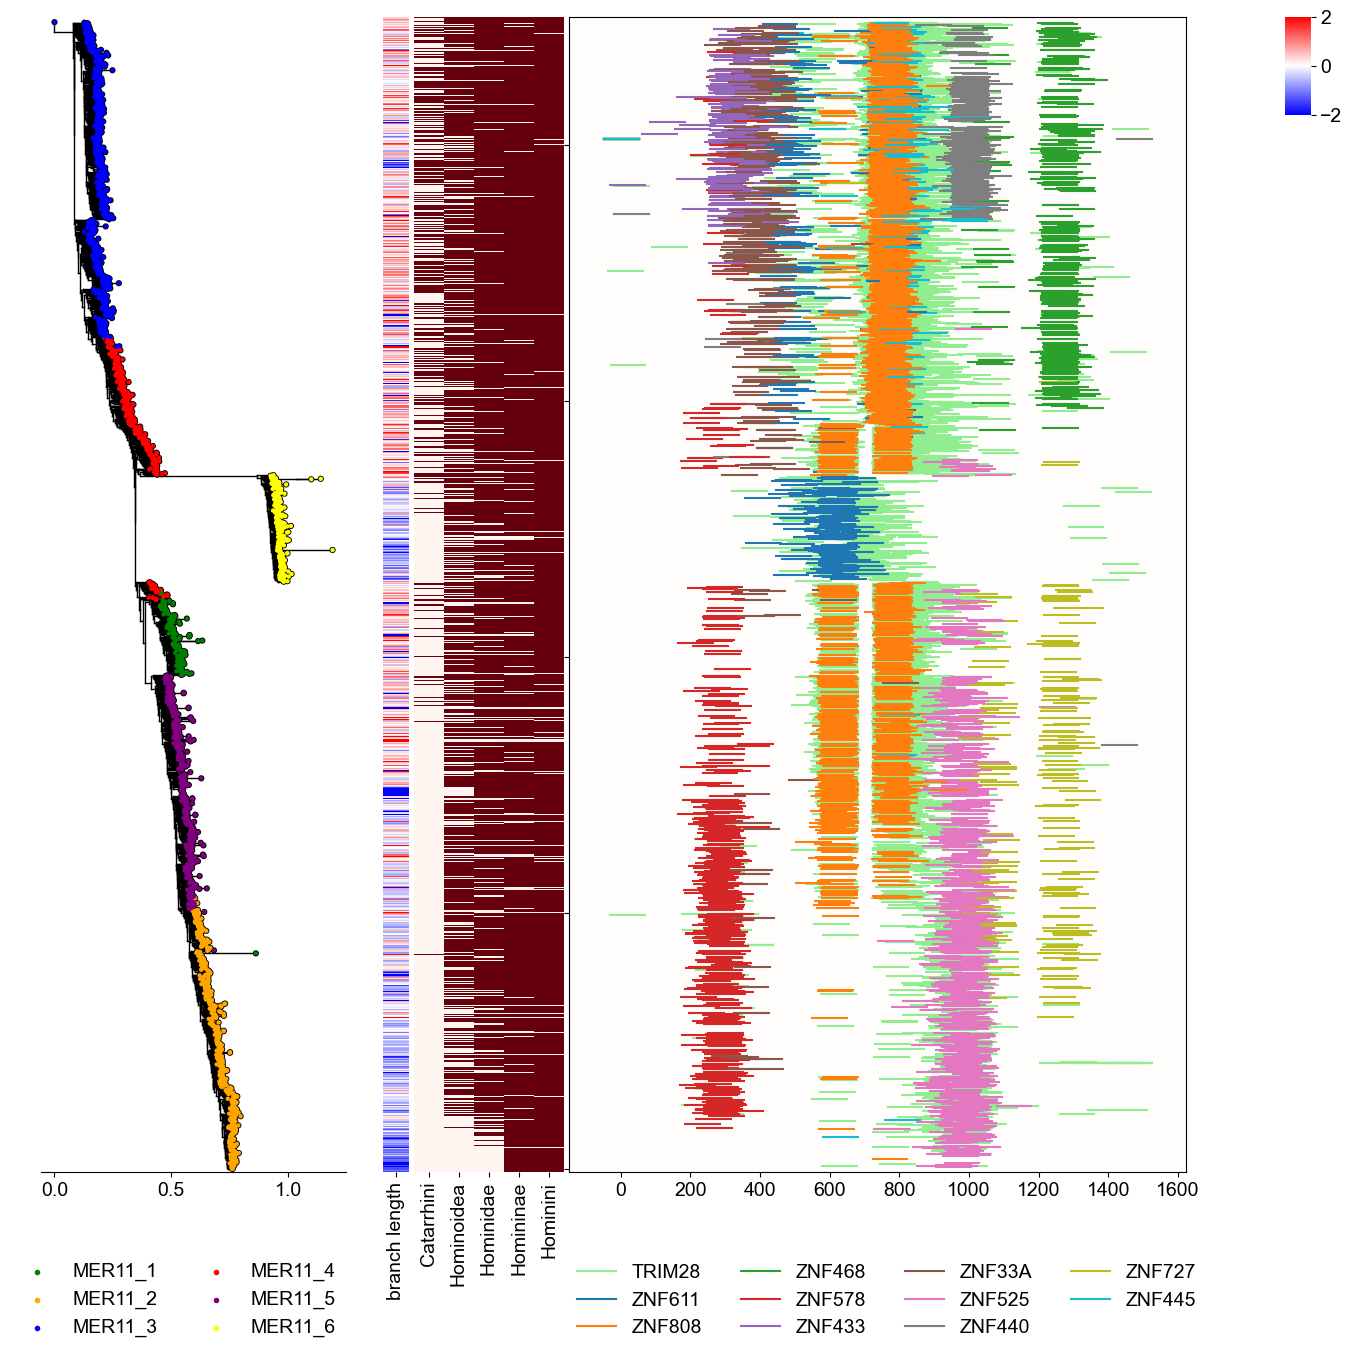

In [12]:
# phylogenetic tree
family_list = pd.unique(Lift_df.index)
family = 'MER11'
i = 0

#height = max([3, np.log10(len(tree.getExternal()))*5])
if len(tree.getExternal())/50 < 3:

    height = 3

elif len(tree.getExternal())/50 > 15:

    height = 15

else:

    height = len(tree.getExternal())/50


fig = plt.figure(figsize=[20, height])
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14

### 系統樹の可視化
gs = GridSpec(10, 50)
ax = plt.subplot(gs[:10, :10])
i = 10

p1 = tree.plotTree(ax=ax, width=1)
p2 = tree.plotPoints(ax=ax, colour=c_func, size=10)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

[ax.spines[loc].set_visible(False) for loc in ['top','right','left']]

ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])
ax.set_ylim(-5,tree.ySpan+10)
#ax.set_title(family)
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

ylim = p1.get_ylim()

# Legend
legend_elements = []
label = ['MER11_{}'.format(k) for k in range(1, 7)]
for k, subfamily in enumerate(Lift_df.index):
    color = color_subfamily_dict[subfamily]
    p = ax.scatter([-1], [-1], marker='.', label=label[k], color=color)

ax.legend(loc=[-0.1, -0.15], ncol=2, fontsize=14, frameon=False)


### branch length    
ax = plt.subplot(gs[:10, i+1])
ax_cbar = plt.subplot(gs[:1, 40])
i += 1

data = Dfam_RM.loc[list(reversed(Dfam_RM['repeat name'].values))]
sns.heatmap(zscore(data['branch length'].to_frame()), vmin=-2, center=0, vmax=2, cmap='bwr', ax=ax, cbar_ax=ax_cbar)

ax.set_yticklabels([])
ax.tick_params(left=False)
ax.set_xticklabels(['branch length'], rotation=90)
ax.set_ylabel('')

### LiftOver
summary = Lift_summary_df.loc[list(reversed(Dfam_RM['repeat name']))][branch_list[12:]]
ax = plt.subplot(gs[:10, i+1:i+len(summary.columns)+1])
i += len(summary.columns) + 1

sns.heatmap(summary, vmin=0, vmax=1, cmap='Reds', ax=ax, cbar=False)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.tick_params(left=False)


### visualize TRIM28 and KZFP peaks
ax = plt.subplot(gs[:10, i:i+20])
i += 20

# TRIM28
ax.set_facecolor('seashell')
ax.patch.set_alpha(0.2)

name_order_dict = dict()
for i, (name) in enumerate(Dfam_RM['repeat name'].values):

    name_order_dict[name] = i

for name, summit in TRIM28_df[['repeat name', 'summit position in repeat alignment']].values:

    order = name_order_dict[name]
    summit = float(summit)

    x = [summit-50, summit+50]
    y = [order, order]
    ax.plot(x, y, c='lightgreen')


# KZFP
color_list = list(mcolors.TABLEAU_COLORS.keys()) + ['darkslategray']
color_dict = dict()

evasion_target = screening_result
primary_target = KZFP_target[(KZFP_target['rank']=='Primary') & (KZFP_target['repeat family name']==family)]
target_list = list(pd.unique(evasion_target['KZFP gene symbol'])) + list(pd.unique(primary_target['KZFP gene symbol']))

print(pd.unique(evasion_target['KZFP gene symbol']))
print(pd.unique(primary_target['KZFP gene symbol']))

target_list = set(target_list)

print(len(target_list))

for i, gene in enumerate(target_list):

    color_dict[gene] = color_list[i%len(color_list)]

print(family, color_dict)

color_dict = {'ZNF611': 'tab:blue', 'ZNF808': 'tab:orange', 'ZNF468': 'tab:green', 'ZNF578': 'tab:red', 
              'ZNF433': 'tab:purple', 'ZNF33A': 'tab:brown', 'ZNF525': 'tab:pink', 'ZNF440': 'tab:gray', 
              'ZNF727': 'tab:olive', 'ZNF445': 'tab:cyan'}

# binding profile
for gene, name, summit in KZFP_df[['KZFP gene symbol', 'repeat name', 'summit position in repeat alignment']].values:

    order = name_order_dict[name]
    summit = float(summit)
        
    if gene in color_dict.keys():
        
        x = [summit-50, summit+50]
        y = [order, order]
        color = color_dict[gene]
        ax.plot(x, y, c=color)


length = 1476

ax.set_xlim(-length*0.1, length*1.1)
ax.set_ylim(ylim[0], ylim[1])
ax.set_yticklabels([])


# Legend
legend_labels = ['TRIM28'] + list(color_dict.keys())
color_dict['TRIM28'] = 'lightgreen'
for label in legend_labels:
    p = ax.plot([0], [0], marker='',label=label, color=color_dict[label])

ax.legend(loc=[0, -0.15], ncol=4, fontsize=14, frameon=False)


fig.savefig('../Figure/Figure3/Figure3C.png', bbox_inches='tight', dpi=300)
fig.savefig('../Figure/Figure3/Figure3C.pdf', bbox_inches='tight', transparent=True, dpi=300)


# Fig.3D

In [13]:
motif = motif_metadata_df_nodup[motif_metadata_df_nodup['KZFP gene symbol']=='ZNF468']
motif

,repeat family name,KZFP gene symbol,KZFP experiment,motif start,motif end,motif center,motif strand,peak overlap motif,discovery proportion,distance to peak summit,log10 p-value,E-value significant figure,E-value log10
12,MER11,ZNF468,GSE78099,1251.0,1271.0,1261,+,193.0,76.587302,7.248705,6.497573,1.7,817


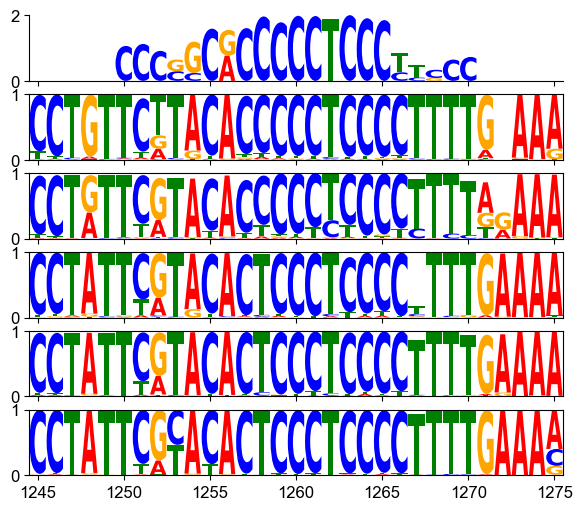

In [14]:
import logomaker
from scipy.stats import spearmanr
from matplotlib.gridspec import GridSpec

color_dict = {'A': 'red', 'T': 'green', 'C': 'blue', 'G': 'orange'}

columns = ['repeat family name', 'KZFP gene symbol', 'KZFP experiment', 'motif start', 'motif end', 'motif strand', 'peak overlap motif', 'discovery proportion', 'log10 p-value']

family, KZFP, exp, start, end, strand, overlap_count, discovery, motif_pvalue = motif[columns].values.tolist()[0]
        
start = int(start)
end = int(end)

cluster_list = ['MER11_2', 'MER11_3', 'MER11_0', 'MER11_4', 'MER11_1']

fig = plt.figure(figsize=[20, (len(cluster_list)+2)*1])
gs = GridSpec(len(cluster_list)+2, 20)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

ax_list = list()

ax_list.append(ax)

# motf
ax = plt.subplot(gs[0, 7:14])
data = (motif_matrix_df[(KZFP, exp)]/0.25).apply(np.log2)

if strand == '-':
    data = data.sort_index(ascending=False)[['T', 'G', 'C', 'A']]
            
data = pd.DataFrame(np.where(data>=0, data, 0), columns=['A', 'C', 'G', 'T'])

logomaker.Logo(data, 
               color_scheme=color_dict, 
               ax=ax)

#ax.set_ylabel('motif', rotation=0)
ax.set_xticklabels('')
#ax.set_yticklabels('')
ax.set_ylim(0, 2)
ax.set_xlim(0-5.5, len(data)+4.5)
ax.set_xticklabels('')
#ax.set_yticklabels('')

[ax.spines[loc].set_visible(False) for loc in ['top','right']]

ax_list.append(ax)


# conservation level of each subfamily
for i, cluster in enumerate(cluster_list):

    ax = plt.subplot(gs[i+1, 7:14])
            
    data = conserved_dict[cluster].T[['A', 'C', 'G', 'T']][start-10:end+10]
    logomaker.Logo(data, 
                   color_scheme=color_dict, 
                   ax=ax)

    ax.set_ylabel('', rotation=0)
    ax.set_yticklabels([0, 1])
    ax.set_xlim(start-6.5, end+4.5)
    ax.set_ylim(0, 1)

    if i != len(cluster_list)-1 :

        ax.set_xticklabels('')

    ax_list.append(ax)


fig.savefig('../Figure/Figure3/Figure3D.png', bbox_inches='tight', dpi=300)
fig.savefig('../Figure/Figure3/Figure3D.pdf', transparent=True, dpi=300)


# Fig.3E

In [15]:
Dfam_RM_fil = Dfam_RM[Dfam_RM['repeat adjusted subfamily name']!='MER11_5']
KZFP_df_fil = KZFP_df[KZFP_df['repeat name'].isin(Dfam_RM['repeat name'])]

6.6141073663921125e-06


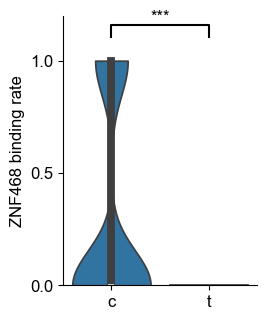

In [16]:
fig = plt.figure(figsize=[2.5, 3.5])
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

ax = plt.subplot()
KZFP_count = KZFP_df_fil[KZFP_df_fil['KZFP gene symbol']=='ZNF468']['repeat name'].value_counts().rename('ZNF468')
data = pd.concat([Dfam_RM_fil, KZFP_count], axis=1)
MSA_fil = MSA_df.loc[data.index]

data = pd.concat([data, MSA_fil[[1258, 1262]]], axis=1)
data = data[data['repeat adjusted subfamily name']=='MER11_3']
data = data[data[1258].isna()==False]

x = data[1258]
y = data['ZNF468'].fillna(0)
order = ['c', 't']

sns.violinplot(x=x, y=y, order=order, scale='width', cut=0, ax=ax)

# Statistical test
C = data[data[1258]=='c']['ZNF468'].fillna(0)
T = data[data[1258]=='t']['ZNF468'].fillna(0)
p = mannwhitneyu(C, T)[1]
print(p)

barplot_annotate_brackets(0, 1, '***', [0, 1], [1.05, 1.05])

ax.set_yticks([0, 0.5, 1])
ax.set_ylim(0, 1.2)
ax.set_xlabel('')
ax.set_ylabel('ZNF468 binding rate')
[ax.spines[loc].set_visible(False) for loc in ['right', 'top']]

fig.savefig('../Figure/Figure3/Figure3E.png', bbox_inches='tight', dpi=300)
fig.savefig('../Figure/Figure3/Figure3E.pdf', bbox_inches='tight', transparent=True, dpi=300)
